In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import numpy.matlib
import multiprocessing, time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import truncnorm
from joblib import Parallel, delayed
from statistics import mean as st_mean

from FH_Functions import opt_fracs, get_truncated_normal, search_data

In [3]:
def range_Xo_ent(Xc,Xo):
    if Xo == Xc: # State is not possible, treat as neighbor
        if Xo < 0.5:
            Xo = Xc + delta
        else:
            Xo = Xc - delta
    V = np.abs(Xc - Xo)
    return V

def range_Xc_ent(Xc,S):
    V = Parallel(n_jobs=num_cores)(delayed(range_Xo_ent)(Xc,Xo) for Xo in S)
    return V

def range_Xo(idXc,Xc,idXo,Xo,V,S,A):
    Qa3 = []
    if np.abs(idXo-idXc) < 2: # states where we cannot get smaller
        for ii in range(Nactions):
            Qa3.append(V[idXc,idXo])
    elif Xo > Xc:   
        tn = get_truncated_normal(mean, std, Xc, Xo)
        interval = Xo - Xc
        for action in A:
            step = interval*action
            Z = Xc + step 
            idZ = np.argmin(np.abs(S - Z))
            Z = S[idZ]
            chance = tn.cdf(Z)
            Qa3.append(lam*np.abs(Xc-Z) + chance*V[idXc, idZ] + (1-chance)*V[idZ, idXo])

    elif Xo < Xc:
        tn = get_truncated_normal(mean, std, Xo, Xc)
        interval = Xc - Xo
        for action in A:
            step = interval*action
            Z = Xc - step 
            idZ = np.argmin(np.abs(S - Z))
            Z = S[idZ]
            chance = tn.cdf(Z)
            Qa3.append(lam*np.abs(Xc-Z) + chance*V[idXo, idZ] + (1-chance)*V[idZ, idXc])
    return Qa3

def range_Xc(idXc,Xc,V,S,A):
    Qa2 = Parallel(n_jobs=num_cores)(delayed(range_Xo)(idXc,Xc,idXo,Xo,V,S,A) for idXo, Xo in enumerate(S))
    Qa2 = np.stack(Qa2,axis=1)
    Va = np.amin(Qa2,0)
    bA = A[np.argmin(Qa2,0)]
    return Va, bA

In [6]:
# VARIABLES CONTROL VALUES IN ALL FOLLOWING PARALLEL PROCESSES
mean = 0.5
std = 0.1
lam = 0.4
N = 6
Nstates = 501
delta = 1/Nstates
Nactions = 101
num_cores = multiprocessing.cpu_count()
print(num_cores)

16


In [43]:
# Initialize terminal states
S = np.matlib.repmat(np.linspace(0,1,Nstates).T, N, 1)

# Actions
A = np.linspace(0,0.5,Nactions)

# compute value at step N for each length s in S
V = np.zeros((N,Nstates,Nstates))
E = np.zeros((N,Nstates))

# Compute the final entropies
bestAction = np.zeros((N,Nstates,Nstates))

tic = time.time()
V[-1,:,:] = Parallel(n_jobs=num_cores)\
            (delayed(range_Xc_ent)(Xc,S[-1,:]) for Xc in S[-1,:])

# Backwards policy evaluation - PARALLEL
for nn in range(2,N+1):
    print(nn)
    VabA = Parallel(n_jobs=num_cores)(delayed(range_Xc)(idXc,Xc,V[-nn+1,:,:],S[-1,:],A)\
                 for idXc, Xc in enumerate(S[-1,:]))
    VabA2 = np.stack(VabA,axis=1)
    V[-nn,:,:] = VabA2[0]
    bestAction[nn-2,:,:] = VabA2[1]
toc = time.time()       
time_p = toc-tic
print("Time: ",time_p)

2
3
4
5
6
Time:  4127.461236715317


In [ ]:
# STORE ARRAY FOR POLICY EVALUATION
bestAction = np.flipud(bestAction)
np.save('./Policies/DP_bestAction_mu5_sig1_lam4_N5_s501_A101',bestAction)

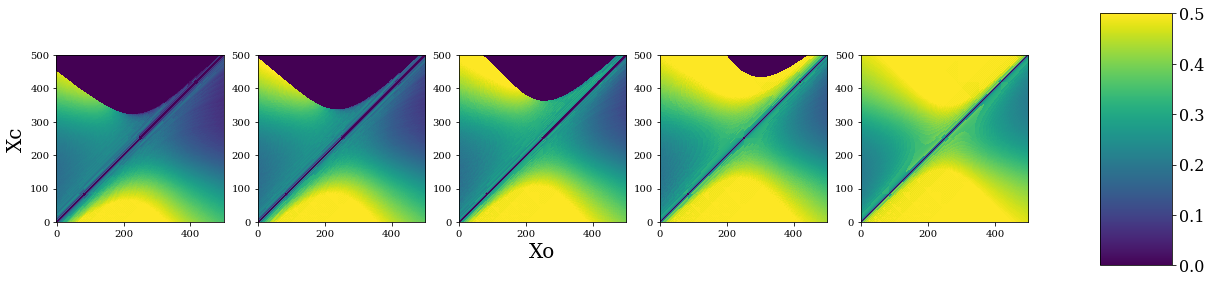

In [34]:
# plt.figure(figsize=(10,10))
%matplotlib inline
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=5)
plt.rc('font',family='serif')

for ii, ax in enumerate(axes.flat):
    bA = bestAction[ii+1,:,:]
    im = ax.imshow(bA, origin='lower')
    if ii == 0:
        ax.set_ylabel('Xc',fontsize=20)
    if ii == 2:
        ax.set_xlabel('Xo',fontsize=20)

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im, cax=cbar_ax);

# fig.tight_layout()
# fig.savefig('NonuniformPolicyHeatmap.eps',bbox_inches='tight');